# MODNet 'matbench_log_gvrh' and 'matbench_log_kvrh' benchmarking

Multi-target benchmarking of the ~11,000 entry elastic properties datasets provided by matminer.

In [1]:
from collections import defaultdict
import itertools
import os
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
from matminer.datasets import load_dataset
from pymatgen.core import Composition

from IPython.display import Markdown
from modnet.preprocessing import MODData
from modnet.models import MODNetModel
from modnet.featurizers import MODFeaturizer
from modnet.featurizers.presets import DeBreuck2020Featurizer

os.environ["CUDA_VISIBLE_DEVICES"] = "1"


If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



In [2]:
Markdown(filename="./README.md")

# matbench_elastic

## Introduction

- Multi-target prediction of Voigt-Reuss-Hill bulk modulus and shear modulus from structures.
- 10,987 structures

Results to beat:

| Method | log K (log(GPa)) | log G (log(GPa)) |
|:-------|-----------------:|-----------------:|
| Automatminer | 0.0679 | 0.0849 |
| MEGNet | 0.0712 | 0.0914 |
| CGCNN | 0.0712 | 0.0895 |

## To-do

- [x] Featurize
- [ ] Feature selection (extremely slow, >months...)

## Notes

- Very slow to do feature selection; need to do sampling

## Results

| Method/architecture | log K (log(GPa)) | log G (log(GPa)) |
|:--------------------|-----------------:|-----------------:|
| MODNet              |                  |                  |


## Data exploration

In [3]:
df_gvrh = load_dataset("matbench_log_gvrh")
df_kvrh = load_dataset("matbench_log_kvrh")

In [4]:
df_combined = pd.DataFrame(df_gvrh)
df_combined["log10(K_VRH)"] = df_kvrh["log10(K_VRH)"]

In [5]:
df_temp = df_combined[['structure']]
df_temp['structure_dict'] = df_temp['structure'].apply(lambda x: x.as_dict())
df_temp = df_temp.drop('structure',axis=1)
df_temp.to_csv('df_GK_struc.csv')

### Target space

In [6]:
df_combined.describe()

,log10(G_VRH),log10(K_VRH)
count,10987.000000,10987.000000
mean,1.553639,1.880446
std,0.371615,0.369331
min,0.000000,0.000000
25%,1.342423,1.672098
50%,1.579784,1.934498
75%,1.826075,2.158362
max,2.718502,2.759668


Text(0, 0.5, 'log10(K_VRH)')

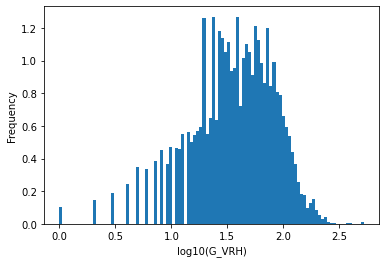

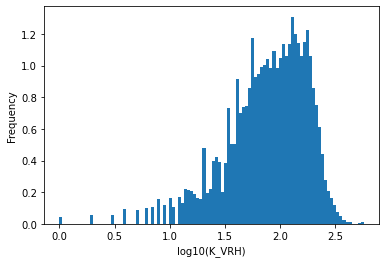

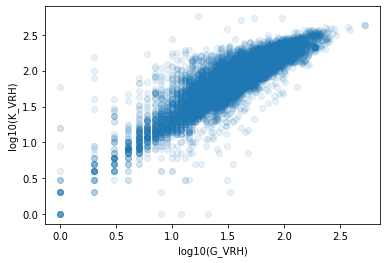

In [7]:
fig, ax = plt.subplots(facecolor="w")
ax.hist(df_combined["log10(G_VRH)"], bins=100, density=True);
ax.set_ylabel("Frequency")
ax.set_xlabel("log10(G_VRH)")
fig, ax = plt.subplots(facecolor="w")
ax.hist(df_combined["log10(K_VRH)"], bins=100, density=True);
ax.set_ylabel("Frequency")
ax.set_xlabel("log10(K_VRH)")
fig, ax = plt.subplots(facecolor="w")
ax.scatter(df_combined["log10(G_VRH)"], df_combined["log10(K_VRH)"], alpha=0.1)
ax.set_xlabel("log10(G_VRH)")
ax.set_ylabel("log10(K_VRH)")

## Featurization and feature selection

In [25]:
PRECOMPUTED_MODDATA = "./precomputed/elastic_benchmark_moddata_MPCNMI.pkl.gz"

if os.path.isfile(PRECOMPUTED_MODDATA):
    data = MODData.load(PRECOMPUTED_MODDATA)
else:
    data = MODData(
        structures=df_combined["structure"].tolist(), 
        targets=df_combined[["log10(G_VRH)", "log10(K_VRH)"]],
        target_names=["log10(G_VRH)", "log10(K_VRH)"],
        featurizer=DeBreuck2020Featurizer(n_jobs=8)
    )
    data.featurize()
    # As this is a small data/feature set, order all features 
    data.feature_selection(n=-1)

INFO:root:Loaded <modnet.preprocessing.MODData object at 0x7fcd876b3d30> object, created with modnet version 0.1.8~develop


In [26]:
#data.num_classes = {"log10(G_VRH)":0, "log10(K_VRH)":0}
#data.feature_selection(n=-1)
#data.save("./precomputed/elastic_benchmark_moddata_MPCNMI.pkl.gz")

In [27]:
#data.save("./precomputed/elastic_benchmark_moddata_MPCNMI.pkl.gz")

In [28]:
data.df_targets

,log10(G_VRH),log10(K_VRH)
id0,1.447158,1.707570
id1,1.518514,1.633468
id2,1.740363,1.908485
id3,1.707570,2.117271
id4,1.602060,1.690196
...,...,...
id10982,1.414973,1.778151
id10983,1.431364,1.724276
id10984,1.000000,1.342423
id10985,1.579784,1.770852


## Training

This is a very small dataset, so we must make judicious use of what data there is. First, let's generate test folds according to [matbench's suggestions](https://hackingmaterials.lbl.gov/automatminer/datasets.html#benchmarking-and-reporting-your-algorithm):

In [31]:
data.df_targets.columns=['G','K']
try:
    plot_benchmark
except:
    import sys
    sys.path.append('..')
    from modnet_matbench.utils import *
    
from sklearn.model_selection import KFold
from modnet.models import MODNetModel
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

best_settings = {
    "increase_bs":False,
    "num_neurons": [[256], [64], [64], [32]],
    "n_feat": 350,
    "lr": 0.01,
    "epochs": 200,
    "verbose": 0,
    "act": "elu",
    "batch_size": 64,
    "loss": "mae",
    
}

results = matbench_benchmark(data, [[["G"],["K"]]], {"G": 1, "K":1}, best_settings,multi=True,save_folds=True)
np.mean(np.array(results["scores"])[[0,1,2,4]],axis=0)

INFO:root:Compiling model...
INFO:root:Fitting model...


Model #1: MAE = [0.07898848 0.05854952]


INFO:root:Compiling model...
INFO:root:Fitting model...


Model #2: MAE = [0.09394978 0.074667  ]


INFO:root:Compiling model...
INFO:root:Fitting model...


Model #3: MAE = [0.07890025 0.05582615]


INFO:root:Compiling model...
INFO:root:Fitting model...


Model #4: MAE = [ 2.64086913 24.68951497]


INFO:root:Compiling model...
INFO:root:Fitting model...


Model #5: MAE = [0.08647578 0.06612804]


array([0.08457857, 0.06379268])

In [44]:
errors_K = []
errors_G = []
for f in range(5):
    df = pd.read_csv('folds/test_f{}.csv'.format(f+1),index_col=0)
    if f==3:
        print(df['K_error'].abs().nlargest(n=5))
        df = df.drop('id6951')
    print(df['K_error'].abs().describe())
    errors_K.append(df['K_error'].abs().mean())
    errors_G.append(df['G_error'].abs().mean())
print(np.mean(errors_K))
print(np.mean(errors_G))

count    2198.000000
mean        0.058550
std         0.086739
min         0.000032
25%         0.014958
50%         0.032772
75%         0.066891
max         1.592142
Name: K_error, dtype: float64
count    2198.000000
mean        0.074667
std         0.193456
min         0.000038
25%         0.021860
50%         0.046441
75%         0.082682
max         7.980914
Name: K_error, dtype: float64
count    2197.000000
mean        0.055826
std         0.083313
min         0.000060
25%         0.014277
50%         0.030809
75%         0.062906
max         1.206394
Name: K_error, dtype: float64
id
id6951     54107.837275
id10605        1.288851
id5845         0.922461
id4537         0.900193
id7030         0.894927
Name: K_error, dtype: float64
count    2196.000000
mean        0.061488
std         0.097603
min         0.000018
25%         0.015042
50%         0.032031
75%         0.065414
max         1.288851
Name: K_error, dtype: float64
count    2197.000000
mean        0.066128
std         0

In [51]:
data.df_structure.loc['id6951']['structure'].formula

'Pt1 Rh3'

In [ ]:
for i,c in zip(range(5),['b','k','r','g','y']):
    plt.plot(results["models"][i].history.history["loss"][50:],c=c)